In [1]:
# Import necessary libraries and check GPU availability
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available and will be used.")
else:
    print("GPU is not available, using CPU instead.")

GPU is available and will be used.


In [2]:
# Dataset paths and image size
train_loc = '/kaggle/input/mpox-skin-lesion-dataset-version-20-msld-v20/Augmented Images/Augmented Images/FOLDS_AUG/fold1_AUG/Train'
valid_loc = '/kaggle/input/mpox-skin-lesion-dataset-version-20-msld-v20/Original Images/Original Images/FOLDS/fold1/Valid'
test_loc = '/kaggle/input/mpox-skin-lesion-dataset-version-20-msld-v20/Original Images/Original Images/FOLDS/fold1/Test'

In [3]:
img_size = (224, 224)
batch_size = 16

In [4]:
# # Data augmentation strategy
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=40,
#     width_shift_range=0.4,
#     height_shift_range=0.4,
#     shear_range=0.3,
#     zoom_range=0.3,
#     horizontal_flip=True,
#     vertical_flip=True,
#     brightness_range=[0.7, 1.3],
#     fill_mode='nearest'
# )

# test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
# Function to create data augmentation pipelines
def augment_class_specific(class_name):
    if class_name in ['Chickenpox', 'Monkeypox']:
        # More aggressive augmentations for Chickenpox and Monkeypox
        return ImageDataGenerator(
            rescale=1./255,
            rotation_range=60,
            width_shift_range=0.5,
            height_shift_range=0.5,
            shear_range=0.4,
            zoom_range=0.5,
            horizontal_flip=True,
            vertical_flip=True,
            brightness_range=[0.5, 1.5],
            fill_mode='nearest',
            preprocessing_function=lambda img: tf.image.random_contrast(img, lower=0.8, upper=1.2)
        )
    else:
        # Lighter augmentations for other classes
        return ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.4,
            height_shift_range=0.4,
            shear_range=0.3,
            zoom_range=0.3,
            horizontal_flip=True,
            brightness_range=[0.7, 1.3],
            fill_mode='nearest'
        )

# Test data augmentation (no augmentation, only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
# # Load the dataset with train, validation, and test generators
# def load_data():
#     train_generator = train_datagen.flow_from_directory(
#         train_loc, target_size=img_size, batch_size=batch_size, class_mode='categorical'
#     )
    
#     validation_generator = train_datagen.flow_from_directory(
#         valid_loc, target_size=img_size, batch_size=batch_size, class_mode='categorical'
#     )
    
#     test_generator = test_datagen.flow_from_directory(
#         test_loc, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False
#     )
    
#     return train_generator, validation_generator, test_generator

# train_generator, validation_generator, test_generator = load_data()

In [7]:
# Function to load data with class-specific augmentations
def load_data():
    train_datagen = augment_class_specific("Chickenpox")
    validation_datagen = augment_class_specific("Monkeypox")
    
    train_generator = train_datagen.flow_from_directory(
        train_loc, target_size=img_size, batch_size=batch_size, class_mode='categorical'
    )
    
    validation_generator = validation_datagen.flow_from_directory(
        valid_loc, target_size=img_size, batch_size=batch_size, class_mode='categorical'
    )
    
    test_generator = test_datagen.flow_from_directory(
        test_loc, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False
    )
    
    return train_generator, validation_generator, test_generator

train_generator, validation_generator, test_generator = load_data()

Found 7518 images belonging to 6 classes.
Found 144 images belonging to 6 classes.
Found 74 images belonging to 6 classes.


In [8]:
# Compute class weights to handle imbalance
labels = train_generator.classes
class_weights_inception = class_weight.compute_class_weight(class_weight='balanced', 
                                                  classes=np.unique(labels), 
                                                  y=labels)
class_weights_dict_inception = dict(enumerate(class_weights_inception))

In [9]:
# Build the InceptionV3 model
def build_inceptionv3_model(input_shape=(224, 224, 3), num_classes=6):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Fine-tune the last 100 layers of InceptionV3
    for layer in base_model.layers[-150:]:
        layer.trainable = True
    
    # Add custom layers for classification
    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Build the model
model_inception = build_inceptionv3_model()

# Callbacks for early stopping, learning rate reduction, and model checkpoint
checkpoint_inception = ModelCheckpoint("best_model_inceptionv3.keras", monitor='val_accuracy', save_best_only=True)
early_stopping_inception = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
lr_scheduler_inception = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

# Train the model with class weights and callbacks
history_inception = model_inception.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    class_weight=class_weights_dict_inception,
    callbacks=[checkpoint_inception, early_stopping_inception, lr_scheduler_inception]
)

# Evaluate the model on the test set
test_loss_inception, test_acc_inception = model_inception.evaluate(test_generator)
print(f"Test accuracy: {test_acc_inception}")

# Save the final model
model_inception.save('final_inceptionv3_model.keras')

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1729128495.264438     114 service.cc:145] XLA service 0x79c9dc0025b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729128495.264494     114 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/470 ━━━━━━━━━━━━━━━━━━━━ 10:15:47 79s/step - accuracy: 0.3125 - loss: 2.1328

I0000 00:00:1729128535.984599     114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


470/470 ━━━━━━━━━━━━━━━━━━━━ 315s 504ms/step - accuracy: 0.2469 - loss: 2.4092 - val_accuracy: 0.3333 - val_loss: 1.8557 - learning_rate: 1.0000e-04
Epoch 2/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 150s 315ms/step - accuracy: 0.4128 - loss: 1.6143 - val_accuracy: 0.5208 - val_loss: 1.4169 - learning_rate: 1.0000e-04
Epoch 3/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 152s 320ms/step - accuracy: 0.4960 - loss: 1.3414 - val_accuracy: 0.5972 - val_loss: 1.1696 - learning_rate: 1.0000e-04
Epoch 4/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 149s 314ms/step - accuracy: 0.5567 - loss: 1.1631 - val_accuracy: 0.5972 - val_loss: 1.1816 - learning_rate: 1.0000e-04
Epoch 5/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 150s 316ms/step - accuracy: 0.6155 - loss: 1.0285 - val_accuracy: 0.5833 - val_loss: 1.2237 - learning_rate: 1.0000e-04
Epoch 6/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 151s 318ms/step - accuracy: 0.6525 - loss: 0.8948 - val_accuracy: 0.6389 - val_loss: 1.0786 - learning_rate: 2.0000e-05
Epoch 7/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 153s 323ms/

5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
Classification Report for InceptionV3 Model:
              precision    recall  f1-score   support

  Chickenpox       0.57      0.89      0.70         9
      Cowpox       0.50      0.29      0.36         7
        HFMD       0.89      1.00      0.94        16
     Healthy       0.67      0.89      0.76         9
     Measles       1.00      1.00      1.00         6
   Monkeypox       0.85      0.63      0.72        27

    accuracy                           0.77        74
   macro avg       0.75      0.78      0.75        74
weighted avg       0.78      0.77      0.76        74

Precision: 0.7812848562848563
Recall: 0.7702702702702703
F1 Score: 0.7601919647411294


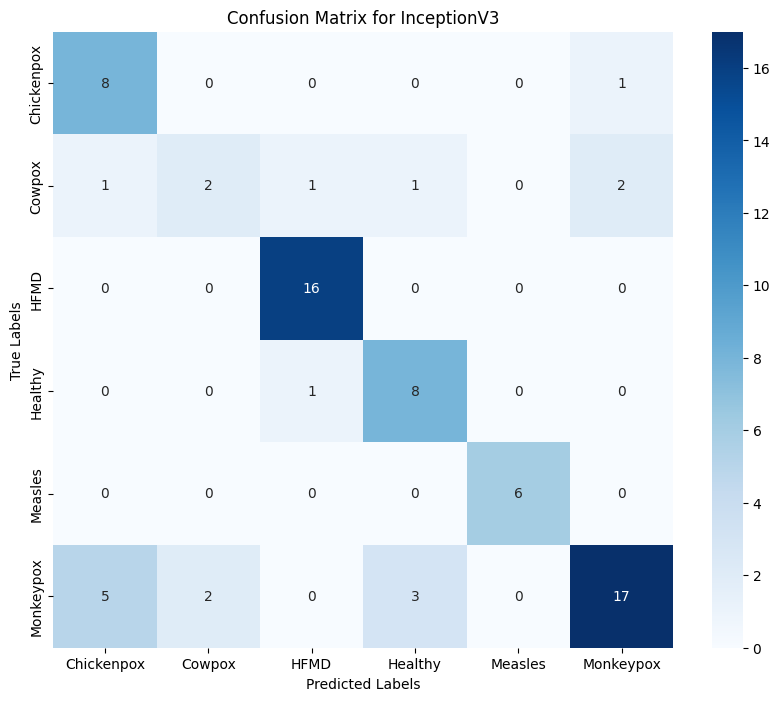

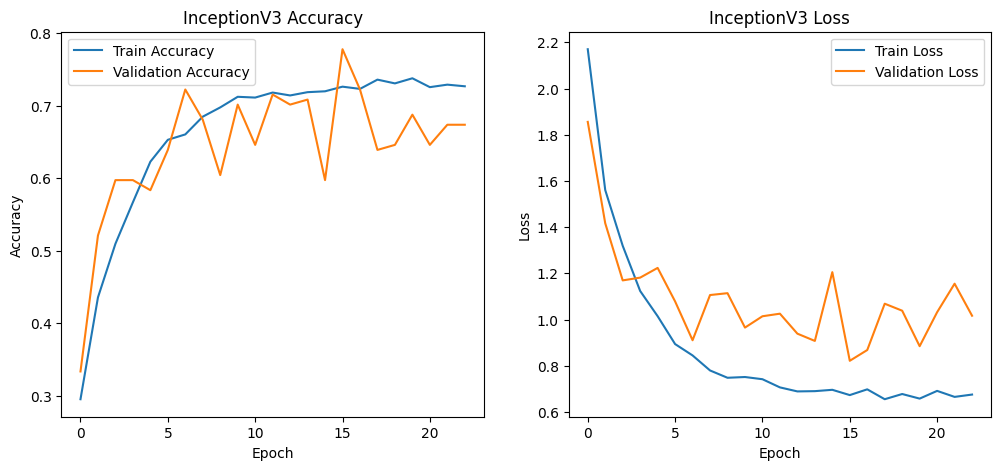

In [10]:
# Predictions on the test set
preds_inception = model_inception.predict(test_generator)
y_preds_inception = np.argmax(preds_inception, axis=1)
y_true_inception = test_generator.classes

# Classification report
print("Classification Report for InceptionV3 Model:")
print(classification_report(y_true_inception, y_preds_inception, target_names=test_generator.class_indices.keys()))

# Compute accuracy, precision, recall, and F1-score
accuracy_inception = accuracy_score(y_true_inception, y_preds_inception)
precision_inception = precision_score(y_true_inception, y_preds_inception, average='weighted', zero_division=0)
recall_inception = recall_score(y_true_inception, y_preds_inception, average='weighted', zero_division=0)
f1_inception = f1_score(y_true_inception, y_preds_inception, average='weighted', zero_division=0)

print(f"Precision: {precision_inception}")
print(f"Recall: {recall_inception}")
print(f"F1 Score: {f1_inception}")

# Confusion matrix
cm_inception = confusion_matrix(y_true_inception, y_preds_inception)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_inception, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_generator.class_indices.keys(), 
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix for InceptionV3')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Function to plot training history
def plot_training_history(history, model_name="Model"):
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

# Plot training history
plot_training_history(history_inception, model_name="InceptionV3")